# Triplet Network Evaluation


In [1]:
# Move to the directory where the notebook is located
# and set directory to Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
%cd ..

c:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\PPNC\Project\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Đảm bảo đang ở Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
# Cài đặt package
!pip install -e .

Obtaining file:///C:/Users/USER/Downloads/ch%C6%B0%C6%A1ng%20tr%C3%ACnh%20h%E1%BB%8Dc%20UEH/m%C3%B4n%20h%E1%BB%8Dc%20k%C3%AC%204/PPNC/Project/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for signature_verification (pyproject.toml): started
  Building editable for signature_verification (pyproject.toml): finished with status 'done'
  Created wheel for signature_verification: filename=signature_verification-0.1.0-0.editable-py3-none-any.whl s


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import sys
import time
import gc
import random
import psutil
import shutil
import kagglehub
import itertools

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

from utils.helpers import load_config, get_model_from_Kaggle, load_model
from models.feature_extractor import ResNetFeatureExtractor
from models.Triplet_Siamese_Similarity_Network import tSSN
from dataloader.tSSN_testloader import SignatureTestDataset

In [4]:
print(os.getcwd())

c:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\PPNC\Project\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


## 1. Load Model  
- Load config, model, transform


In [5]:
# Load configuration
config = load_config('configs/config_tSSN.yaml')

# Device
device = torch.device('cuda' if torch.cuda.is_available() and config['device']=='cuda' else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Download models from Kaggle
model_path = get_model_from_Kaggle(config['model']['kaggle_handle'])

Model downloaded to C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1


In [ ]:
# Define metrics and margins to test
metrics = ['cosine', 'euclidean', 'manhattan']
margins = [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

# Load all models
models = {}
for metric in metrics:
    for margin in margins:
        params = {'mode': metric, 'margin': margin}
        model = load_model(model_path, config['model']['backbone'], config['model']['feature_dim'], params)
        models[f"{metric}_{margin}"] = (model, metric)
print('All models loaded successfully.')

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.2\tSSN.pth
Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.4\tSSN.pth
Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.6000000000000001\tSSN.pth
Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.8\tSSN.pth
Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_1.0\tSSN.pth
Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_euclidean_0.2\tSSN.pth
Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_euclidean_0.4\tSSN.pth
Loaded model 

In [9]:
for _ in models:
    print(_)

cosine_0.2
cosine_0.4
cosine_0.6000000000000001
cosine_0.8
cosine_1.0
euclidean_0.2
euclidean_0.4
euclidean_0.6000000000000001
euclidean_0.8
euclidean_1.0
manhattan_0.2
manhattan_0.4
manhattan_0.6000000000000001
manhattan_0.8
manhattan_1.0


## 2. Dataset Processing

In [6]:
# Image transform
size = config['dataset']['input_size']
if isinstance(size, str):
    size = tuple(map(int, size.strip('()').split(',')))
transform = transforms.Compose([
    transforms.Resize((220, 150)),
    transforms.Grayscale(),  # Đảm bảo ảnh 1 kênh xám
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1 kênh -> 3 kênh
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
pathA = kagglehub.dataset_download("divyanshrai/handwritten-signatures")
print("Path to dataset files [divyanshrai]:", pathA) #dataset A

Path to dataset files [divyanshrai]: C:\Users\USER\.cache\kagglehub\datasets\divyanshrai\handwritten-signatures\versions\2


In [11]:
dataset = r'C:\Users\USER\.cache\kagglehub\datasets\divyanshrai\handwritten-signatures\versions\2\sample_Signature\sample_Signature'
sys.path.append(dataset)

In [12]:
def rename_files(dataset_path):
    # Tạo các thư mục genuines và forged nếu chưa có
    genuines_dir = os.path.join(dataset_path, 'genuines_rename')
    forged_dir = os.path.join(dataset_path, 'forged_rename')
    os.makedirs(genuines_dir, exist_ok=True)
    os.makedirs(forged_dir, exist_ok=True)

    # Duyệt qua tất cả các file trong dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.startswith('NFI-') and (file.endswith('.png') or file.endswith('.PNG')):
                # Trích xuất XXX, YY, ZZZ từ tên file
                parts = file.split('-')[1].split('.')[0]
                XXX = parts[:3]  # ID người thực hiện chữ ký
                YY = parts[3:5]  # Số thứ tự mẫu ảnh
                ZZZ = parts[5:]  # ID người sở hữu chữ ký

                # Xác định là genuine hay forged và đặt tên mới
                if XXX == ZZZ:
                    new_name = f'original_{ZZZ}_{YY}.png'
                    target_dir = genuines_dir
                else:
                    new_name = f'forgery_{ZZZ}_{YY}.png'
                    target_dir = forged_dir

                # Đường dẫn file cũ và mới
                old_path = os.path.join(root, file)
                new_path = os.path.join(target_dir, new_name)

                # Di chuyển và đổi tên file
                shutil.move(old_path, new_path)
                print(f'Đã đổi tên: {file} -> {new_name}')

dataset_path = dataset
rename_files(dataset_path)

In [ ]:
genuines_dir = dataset + '/genuines_rename'
forgery_dir = dataset + '/forged_rename'

# Tạo dataset
dataset = SignatureTestDataset(genuines_dir, forgery_dir, transform=transform)
batch_size = 32  # Chọn kích thước batch phù hợp
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f'Test dataset loaded with {len(dataset)} pairs.')

In [14]:
# Preprocess data: Organize signatures by writer ID
writers = defaultdict(lambda: {'genuines': [], 'forged': []})

# Parse genuine signatures
for fname in os.listdir(genuines_dir):
    if fname.lower().endswith(('.png')):
        parts = fname.split('_')
        if len(parts) == 3 and parts[0] == 'original':
            writer_id = parts[1]  # e.g., '001' from 'original_001_01.png'
            writers[writer_id]['genuines'].append(os.path.join(genuines_dir, fname))

# Parse forged signatures
for fname in os.listdir(forgery_dir):
    if fname.lower().endswith(('.png')):
        parts = fname.split('_')
        if len(parts) == 3 and parts[0] == 'forgery':
            # e.g., '001' from 'forgery_001_01.png'
            writer_id = parts[1]  
            writers[writer_id]['forged'].append(os.path.join(forgery_dir, fname))

print(f"Number of writers: {len(writers)}")
# Print sample
for writer_id, data in list(writers.items())[:32]:  
    print(f"Writer {writer_id}: {len(data['genuines'])} genuines, {len(data['forged'])} forged")

Number of writers: 30
Writer 001: 5 genuines, 5 forged
Writer 002: 5 genuines, 5 forged
Writer 003: 5 genuines, 5 forged
Writer 004: 5 genuines, 5 forged
Writer 005: 5 genuines, 5 forged
Writer 006: 5 genuines, 5 forged
Writer 007: 5 genuines, 5 forged
Writer 008: 5 genuines, 5 forged
Writer 009: 5 genuines, 5 forged
Writer 010: 5 genuines, 4 forged
Writer 011: 5 genuines, 5 forged
Writer 012: 5 genuines, 5 forged
Writer 013: 5 genuines, 5 forged
Writer 014: 5 genuines, 5 forged
Writer 015: 5 genuines, 5 forged
Writer 016: 5 genuines, 5 forged
Writer 017: 5 genuines, 5 forged
Writer 018: 5 genuines, 5 forged
Writer 019: 5 genuines, 5 forged
Writer 020: 5 genuines, 5 forged
Writer 021: 5 genuines, 5 forged
Writer 022: 5 genuines, 5 forged
Writer 023: 5 genuines, 5 forged
Writer 024: 5 genuines, 5 forged
Writer 025: 5 genuines, 5 forged
Writer 026: 5 genuines, 5 forged
Writer 027: 5 genuines, 5 forged
Writer 028: 5 genuines, 5 forged
Writer 029: 5 genuines, 5 forged
Writer 030: 5 genuine

In [ ]:
# Hàm tính khoảng cách dựa trên metric được chọn
def calculate_distance(anchor_feat, test_feat, metric='euclidean'):
    if metric == 'euclidean':
        return F.pairwise_distance(anchor_feat, test_feat)
    elif metric == 'cosine':
        anchor_feat = F.normalize(anchor_feat, p=2, dim=1)
        test_feat = F.normalize(test_feat, p=2, dim=1)
        return 1 - torch.sum(anchor_feat * test_feat, dim=1)
    elif metric == 'manhattan':
        return torch.sum(torch.abs(anchor_feat - test_feat), dim=1)
    # elif metric == 'learnable':
    #     return distance_net(anchor, positive)
    else:
        raise ValueError(f"Metric không được hỗ trợ: {metric}")

In [16]:
def compute_similarities(dataloader, model, device, metric='euclidean'):
    # Chuyển mô hình sang thiết bị (GPU hoặc CPU)
    model.to(device)
    model.eval()

    true_labels = []
    similarities = []

    with torch.no_grad():
        for (anchor, test_signature), labels in dataloader:
            # Chuyển input sang device
            anchor = anchor.to(device)
            test_signature = test_signature.to(device)
            labels = labels.to(device)

            # Trích xuất vector đặc trưng
            anchor_feat = model.feature_extractor(anchor)
            test_feat = model.feature_extractor(test_signature)

            # Tính khoảng cách
            distances = calculate_distance(anchor_feat, test_feat, metric=metric)
            
            # Lưu kết quả
            true_labels.extend(labels.cpu().numpy())
            similarities.extend(distances.cpu().numpy())

    # Chuyển sang numpy array
    true_labels = np.array(true_labels)
    similarities = np.array(similarities)
    
    return true_labels, similarities

In [19]:
results = []

for key, (model, metric) in models.items():
    model.to(device)
    model.eval()
    
    true_labels, similarities = compute_similarities(dataloader, model, device, metric='euclidean')
    
    # Find optimal threshold
    thresholds = np.linspace(0, max(similarities), 100)
    f1_scores = []
    for thresh in thresholds:
        y_pred = (similarities < thresh).astype(int)
        f1 = f1_score(true_labels, y_pred)
        f1_scores.append(f1)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    # Compute metrics at optimal threshold
    y_pred = (similarities < optimal_threshold).astype(int)
    accuracy = accuracy_score(true_labels, y_pred)
    precision = precision_score(true_labels, y_pred)
    recall = recall_score(true_labels, y_pred)
    
    # Store results
    results.append({
        'metric': metric,
        'margin': float(key.split('_')[1]),
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': optimal_f1
    })
    
    print(f"Model {key}: optimal_threshold={optimal_threshold:.4f}, f1_score={optimal_f1:.4f}, accuracy={accuracy:4f}")

Model cosine_0.2: optimal_threshold=11.5243, f1_score=0.5815, accuracy=0.708241
Model cosine_0.4: optimal_threshold=24.9953, f1_score=0.5684, accuracy=0.634744
Model cosine_0.6000000000000001: optimal_threshold=206.0569, f1_score=0.5267, accuracy=0.427617
Model cosine_0.8: optimal_threshold=68.9347, f1_score=0.5412, accuracy=0.478842
Model cosine_1.0: optimal_threshold=20.3629, f1_score=0.5608, accuracy=0.605791
Model euclidean_0.2: optimal_threshold=2.2420, f1_score=0.5990, accuracy=0.639198
Model euclidean_0.4: optimal_threshold=4.0581, f1_score=0.6019, accuracy=0.634744
Model euclidean_0.6000000000000001: optimal_threshold=2.5034, f1_score=0.6336, accuracy=0.703786
Model euclidean_0.8: optimal_threshold=5.3949, f1_score=0.5945, accuracy=0.641425
Model euclidean_1.0: optimal_threshold=3.8652, f1_score=0.6402, accuracy=0.717149
Model manhattan_0.2: optimal_threshold=2.8453, f1_score=0.6062, accuracy=0.632517
Model manhattan_0.4: optimal_threshold=2.0462, f1_score=0.5847, accuracy=0.66

In [20]:
# Convert results to DataFrame
df = pd.DataFrame(results)

# Find best margin for each metric
best_by_metric = df.groupby('metric').apply(lambda x: x.loc[x['accuracy'].idxmax()])
print("\nBest margin for each metric:")
print(best_by_metric[['margin', 'optimal_threshold', 'f1_score', 'accuracy']])


Best margin for each metric:
           margin  optimal_threshold  f1_score  accuracy
metric                                                  
cosine        0.2          11.524345  0.581470  0.708241
euclidean     1.0           3.865238  0.640227  0.717149
manhattan     0.4           2.046238  0.584699  0.661470


C:\Users\USER\AppData\Local\Temp\ipykernel_21056\1421303731.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_by_metric = df.groupby('metric').apply(lambda x: x.loc[x['accuracy'].idxmax()])


In [21]:
# Find overall best configuration
overall_best = best_by_metric.loc[best_by_metric['accuracy'].idxmax()]
print(f"\nOverall best configuration: metric={overall_best['metric']}, margin={overall_best['margin']}, f1_score={overall_best['f1_score']:4f}, "
      f"accuracy={overall_best['accuracy']:.4f}")


Overall best configuration: metric=euclidean, margin=1.0, f1_score=0.640227, accuracy=0.7171


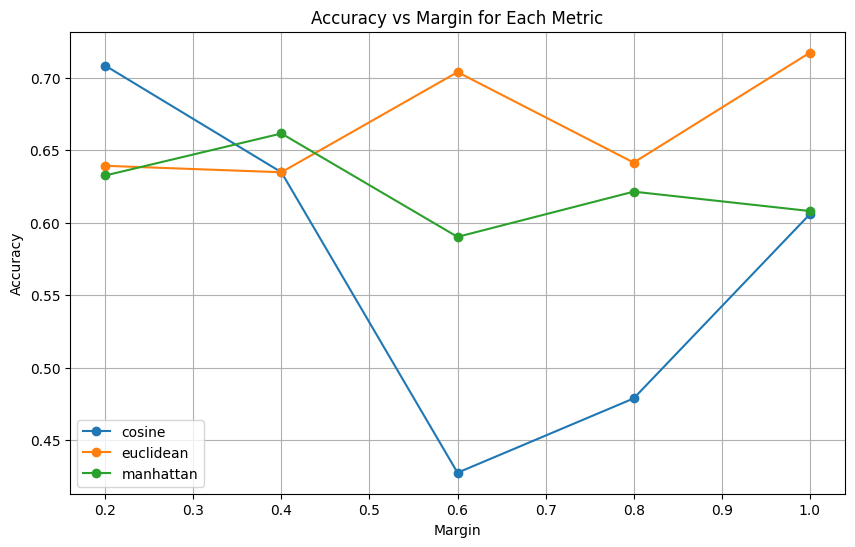

In [22]:
# Plot Accuracy vs Margin for each metric
plt.figure(figsize=(10, 6))
for metric in metrics:
    metric_df = df[df['metric'] == metric]
    plt.plot(metric_df['margin'], metric_df['accuracy'], marker='o', label=metric)
plt.xlabel('Margin')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Margin for Each Metric')
plt.legend()
plt.grid(True)
plt.show()

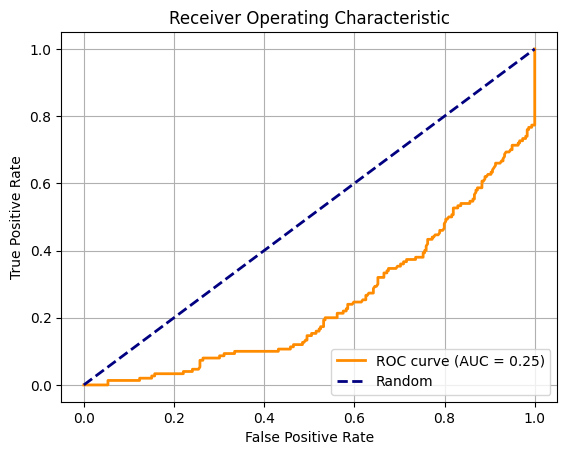

In [23]:
# Giả sử y_true là nhãn thực, y_scores là điểm dự đoán từ mô hình
fpr, tpr, thresholds = roc_curve(true_labels, similarities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)  # Thêm lưới
plt.show()

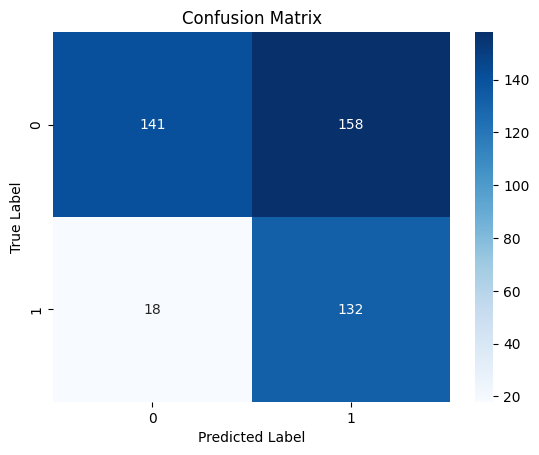

In [24]:
# Giả sử y_true là nhãn thực, y_pred là nhãn dự đoán
cm = confusion_matrix(true_labels, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # annot=True để hiển thị số
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

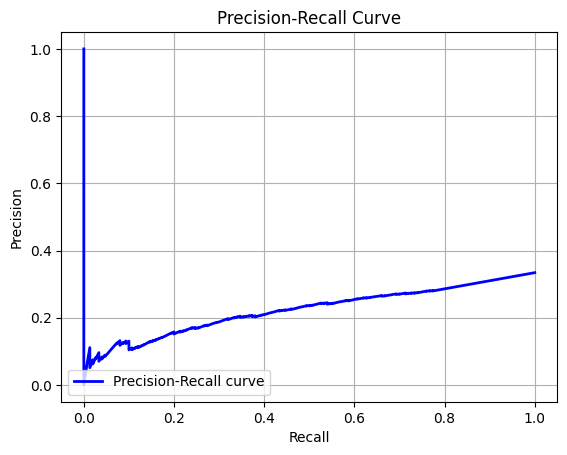

In [25]:
# Giả sử y_true là nhãn thực, y_scores là điểm dự đoán
precision, recall, thresholds = precision_recall_curve(true_labels, similarities)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)  # Thêm lưới
plt.show()